
# **Running Pyspark in Colab**

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 3.0.0 with hadoop 3.2, Java 8 and Findspark to locate the spark in the system. We can use the wget functionality to download these files directly to the current directory. This is instead of downloading the file and then uploading through the interface. This is considerably faster as Google's bandwidth is much faster than my local internet connection.

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [2]:
!wget https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install findspark

--2021-05-08 18:45:33--  https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224453229 (214M) [application/x-gzip]
Saving to: ‘spark-3.0.0-bin-hadoop3.2.tgz.1’

spark-3.0.0-bin-had 100%[===================>] 214.05M  18.5MB/s    in 13s     

2021-05-08 18:45:46 (16.9 MB/s) - ‘spark-3.0.0-bin-hadoop3.2.tgz.1’ saved [224453229/224453229]



We need to set the environment path which enables us to run Pyspark in the Colab environment. Set the location of Java and Spark by running the following code:

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

We must first create a connection to Apache Spark by creating a SparkSession. Each SparkSession must have certain parameters. This can then be paired with a builder
to create the session.

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from time import perf_counter

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Again use the wget function to download the file, and then use bzip2 to uncompress the file. In the backend we are actually using the bunzip2 functionality but bzip2 will check to see if our file is already compressed and will uncompress it, otherwise if the file is currently uncompressed it will compress it.

I conducted the analyses in this notebook using a smaller dataset to start - 2013-02 - with the intention of then changing to a larger, Big Data, data set but this caused problems which I will discuss, which I was unable to solve and sadly had to write my paper from the results that the smaller dataset gave.

Whilst it does not consitute big data itself, the functions I created and the analyses that I did are still coding using Spark SQL, Spark DataFrames, and the like - which should be immediately applicable to much larger datasets if I was able to load them in to memory.

2013-01 is 16.1MB compressed, 92.8MB uncompressed and contains 121,332 games.

2013-02 is 16.4MB compressed, 94.8MB uncompressed and contains 123,961 games.

Both of these files downloaded and unzipped quickly, as can be seen in the cell below. Further when it came to parsing these files they took 6-8 seconds. However, the 2013-03 file is 21.3MB compressed, 122.5MB uncompressed and contains 158,635 games. This file downloaded and unzipped quickly, but when it came to parsing was still not complete after 40 minutes. I am unsure why this happens as all three files are considerably below the available RAM and disk space. This file just hangs at the <code>.select(cols)</code> line.

The same problems occurred on my local machine and on the Google Cloud Platform.

I tried other months from other years which were larger, but should have still fit inside memory, but the same occurred. I believe that the JAVA/Pyspark combination wants to make 4 copies of the data so is inefficient when it comes to RAM use, but even with 4 copies of the data it should have still easily fit inside RAM.

In [5]:
start = perf_counter()
!wget -q https://database.lichess.org/standard/lichess_db_standard_rated_2013-01.pgn.bz2
#!wget -q https://database.lichess.org/standard/lichess_db_standard_rated_2013-02.pgn.bz2
stop = perf_counter()
print("Download time:", round(stop - start,2), "seconds")

start = perf_counter()
!bzip2 -d lichess_db_standard_rated_2013-01.pgn.bz2
#!bzip2 -d lichess_db_standard_rated_2013-02.pgn.bz2
stop = perf_counter()
print("Unzip time:", round(stop - start,2), "seconds")

Download time: 2.63 seconds
bzip2: Output file lichess_db_standard_rated_2013-01.pgn already exists.
Unzip time: 0.12 seconds


In [6]:
from pyspark.sql.types import *

def parse_game_file(game_file):
    from pyspark.sql import functions as F
  
    schema = StructType([
    StructField("_1", StringType(), True), 
    StructField("_2", StringType(), True), 
    ])
    
    load_start = perf_counter()
    basefile = spark.sparkContext.wholeTextFiles(game_file, 5)
    
    load_stop = perf_counter()
    print("Time to load file:", round(load_stop - load_start,2), "seconds")
    
    convert_start = perf_counter()
    basefile = spark.createDataFrame(basefile, schema=schema)
    basefile.printSchema()
    convert_stop = perf_counter()
    print("Conversion time:", round(convert_stop - convert_start, 2), "seconds")
  
    # Create a list of columns we are interested in
    cols = ['White', 'Black', 'Result', 'WhiteElo', 'BlackElo', 'Opening']
    cols = [F.regexp_extract('game', rf'{col} \"(.*)\"',1).alias(col) for col in cols]

    parse_start = perf_counter()

    # We can tell from the schema of the file that we have two columns, _1 and _2.
    # This is an artifact of how Spark creates an RDD from a text file.
    # _2 contains all the useful data we want about the games so we must split this column into
    # multiple columns for their respective headers.

    # selectExpr takes the column _2 and creates a split every time it sees "[Event " and assigns
    # this as a new game.

    # explode(game) now explodes each game into separate rows.

    # We then create a new column to store this game data in, and replace every new line with an empty
    # character. From this we only select columns that we are interested in, which we have specified above
    # with the variable name "cols".
    basefile = basefile.selectExpr("split(_2,'\\\\[Event ') as game") \
        .selectExpr("explode(game) as game") \
        .withColumn("game", F.expr("concat('Event ', replace(game, '\\\\n', ''))"))\
        .select(cols)

    parse_stop = perf_counter()
    print("Time to parse file:", round(parse_stop - parse_start, 2), " seconds for ", basefile.count(), "games.")
    
    # return the Spark Dataframe for use in the analysis
    return basefile

df = parse_game_file('lichess_db_standard_rated_2013-01.pgn')
#dfb = parse_game_file('lichess_db_standard_rated_2013-02.pgn')
#df = dfa.union(dfb)

Time to load file: 0.95 seconds
root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)

Conversion time: 2.64 seconds
Time to parse file: 0.78  seconds for  121333 games.


# Preprocessing

In [7]:
df.show() # Show the file to check our parsing has worked as expected

+-----------------+-----------------+-------+--------+--------+--------------------+
|            White|            Black| Result|WhiteElo|BlackElo|             Opening|
+-----------------+-----------------+-------+--------+--------+--------------------+
|                 |                 |       |        |        |                    |
|            BFG9k|          mamalak|    1-0|    1639|    1403|French Defense: N...|
|   Desmond_Wilson|        savinka59|    1-0|    1654|    1919|Queen's Pawn Game...|
|    Kozakmamay007|VanillaShamanilla|    1-0|    1643|    1747|Four Knights Game...|
| Naitero_Nagasaki|              800|    0-1|    1824|    1973|Caro-Kann Defense...|
|     nichiren1967| Naitero_Nagasaki|    0-1|    1765|    1815|French Defense: L...|
|            sport|         shamirbj|    1-0|    1477|    1487|        Owen Defense|
|          tiggran|          arion_6|    0-1|    1541|    1500|Italian Game: Cla...|
|         hostking|       troepianiz|    1-0|    1765|    1752|En

In [8]:
from pyspark.sql.types import IntegerType # Used for data type transformation
from pyspark.ml.feature import Bucketizer # Used to group the ELO ratings into bins/buckets
from pyspark.sql.window import Window #Creates a window frame over our spark dataframes

# We need to bucketize/bin the player ratings to make analysis easier, however, to do this
# we must first change them from their current string type to integer type. This is because
# Python can not infer which strings are similar to each other in the same way that we can look and
# immediately see that "2" is close to "3". To the computer representing "2" and "3" as strings is no
# different than asking if the strings "cat" and "dog" are similar.
df = df.withColumn("WhiteElo", df["WhiteElo"].cast(IntegerType()))
df = df.withColumn("BlackElo", df["BlackElo"].cast(IntegerType()))

In [9]:
'''
def bucket_black_gr(df):
    # Find the minimum and maximum for Black GR to use these as boundaries for our splits list.
    max_elo = df.agg({"BlackElo": "max"}).collect()[0][0]
    print("The maximum Black ELO is", max_elo)
    min_elo = df.agg({"BlackElo": "min"}).collect()[0][0]
    print("The minimum Black ELO is", min_elo)

    # Using a range split gives us evenly spaced bins that will change depending on the min/max of the data
    # This gives us more flexibility and reduces the amount of hardcoding which may cause problems later.
    splits = list(range(min_elo, max_elo+100, 100))

    # Instantiate Bucketizer
    df = Bucketizer(splits=splits, inputCol="BlackElo", outputCol="BlackEloBin").transform(df)
    return df


def bucket_white_gr(df):
    # Find the minimum and maximum for White GR to use these as boundaries for our splits list.
    max_elo = df.agg({"WhiteElo": "max"}).collect()[0][0]
    print("The maximum White ELO is", max_elo)
    min_elo = df.agg({"WhiteElo": "min"}).collect()[0][0]
    print("The minimum White ELO is", min_elo)

    # Using a range split gives us evenly spaced bins that will change depending on the min/max of the data
    # This gives us more flexibility and reduces the amount of hardcoding which may cause problems later.
    splits = list(range(min_elo, max_elo+100, 100))

    # Instantiate Bucketizerb 
    df = Bucketizer(splits=splits, inputCol="WhiteElo", outputCol="WhiteEloBin").transform(df)
    return df
''';

Above I found the min and max of the elo ratings using the actual minimum and maximum of the dataset. However, this required using the .collect() method 4 times overall which is incredibly slow. Using arbitrary values for the ratings bins which were linearly spaced apart was literally 100 times faster because it did not require the .collect() method. The only downside to this is that I have to overestimate the required range as otherwise it would error if a value took a value where a bin did not exist. I have left the above code for posterity though incase you would like to test the difference yourself.

In [10]:
import numpy as np

def bucket_black_gr(df):
  splits = np.linspace(500, 3300, 15)
  df = Bucketizer(splits=splits, inputCol="BlackElo", outputCol="BlackEloBin").transform(df)
  return df

def bucket_white_gr(df):
  splits = np.linspace(500, 3300, 15)
  df = Bucketizer(splits=splits, inputCol="WhiteElo", outputCol="WhiteEloBin").transform(df)
  return df

In [11]:
# Bin Columns
# Exact ratings will make the analysis much more difficult to conduct and harder to interpret.
# Binning ratings will make our plots easier also.
df = bucket_white_gr(df)
df = bucket_black_gr(df)

# Analysis
I will comment on the functionality and workings of my code here but will save the analysis for the final report saved in the same repo. I have used the function names in the report to make cross referencing easier to retain the ability to read the report side-by-side with the code below.

In [12]:
import matplotlib.pyplot as plt

def top_10_openings():
    # Create a temporary view
    df.createOrReplaceTempView("players")

    # Groupby the the Opening played and count up the number of games that used that opening
    # then pick the 10 most popular.
    top_openings = df.groupby("Opening").count().orderBy('count', ascending=False).limit(10)
    
    # Usually .collect() is a slow process we try to avoid in Big Data, but as we have defined
    # that we only want 10 Openings we can be fairly confident that this usually slow process should
    # be relatively fast.
    opening = top_openings.collect()

    # The output of the collect function gives us the name and count of the Opening, we are only interested
    # in the name of the Opening.
    # Again, for loops are very slow, but for only 10 results they are not hugely detrimental.
    openings = []
    for i in range(len(opening)):
      openings.append(opening[i][0])

    return openings

openings = top_10_openings()

In [13]:
print(openings)

["Van't Kruijs Opening", 'Owen Defense', 'Scandinavian Defense: Mieses-Kotroc Variation', 'Modern Defense', 'Horwitz Defense', 'French Defense: Knight Variation', 'Hungarian Opening', "Queen's Pawn Game: Chigorin Variation", 'Philidor Defense #3', 'Sicilian Defense: Bowdler Attack']


Usually I would run the <code>opening_success</code> function through a for loop, looping over each of the openings. Each of these openings would be fed into the spark.sql query under the <code>where Opening=opening</code> filter. However, this would not work. I believe what I wanted was Dynamic SQL, but I decided to include this particular analysis later in the project and did not have time to learn how to use Dynamic SQL sufficiently to solve my problem. Therefore, to create the graphs of the 10 openings I changed the hardcoded Opening names by hand and saved the outputs.

This is not ideal, and would not be feasible if we had many Openings, however, I took the decision to be time effective and felt the time to solve the problem in the general/n sense outweighed the time to manually change the Opening name.

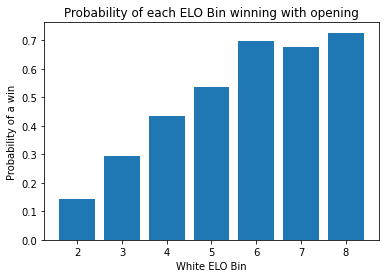

In [15]:
def opening_success():
    import pyspark.sql.functions as f

    # Create a temporary view of the dataframe
    df.createOrReplaceTempView("results")

    # Select all rows from the temp view for this opening
    OpeningResult = spark.sql("SELECT * FROM results where Opening='Modern Defense'")

    # Create a window that partitions by the WhiteEloBin
    window = Window.partitionBy(OpeningResult['WhiteEloBin'])

    # Create a dataframe that is first grouped by WhiteEloBin and then result.
    # This will tell us the number of wins, losses, draws for each bin
    # Calculate the average probability of each elo bin winning, whilst using this opening
    OpeningResult = OpeningResult.groupby("WhiteEloBin", "Result")\
        .count()\
        .withColumn('total', f.sum('count').over(window))\
        .withColumn('fraction', f.col('count')/f.col('total'))

    OpeningResult.createOrReplaceTempView("results")

    # Filter down to only include the rows where White won
    wins = spark.sql("SELECT * FROM results where Result='1-0'").toPandas()
    #loses = spark.sql("SELECT * FROM results where Result='0-1'").toPandas()
    #draws = spark.sql("SELECT * FROM results where Result='1/2-1/2'").toPandas()

    fig = plt.figure()
    plt.bar("WhiteEloBin", "fraction", data=wins)
    plt.title("Probability of each ELO Bin winning with opening")
    plt.xlabel("White ELO Bin")
    plt.ylabel("Probability of a win")
    fig.savefig("Modern Defense.png")
    plt.show()

    return wins

wins = opening_success()

In [16]:
"""
Here we can see the percentage of wins for each WhiteEloBin when playing this specific opening.
We can use this now to compare every player against the expected win rate for this opening to see
if any particular players are consistently outperformming above their expected win ratio for this
opening.
""";
print(wins.sort_values(by=['WhiteEloBin']))

   WhiteEloBin Result  count  total  fraction
4          2.0    1-0      1      7  0.142857
3          3.0    1-0     24     82  0.292683
2          4.0    1-0    188    432  0.435185
6          5.0    1-0    448    834  0.537170
5          6.0    1-0    326    467  0.698073
1          7.0    1-0    101    149  0.677852
0          8.0    1-0      8     11  0.727273


The function <code>find_over_achieving</code> is an extension of <code>opening_success</code> which finds the win ratio for each player who played a specific opening. I have included the tipping point as 50% here which will tell us which players won more often than they lost with this opening. I could have extended this further and compared the result against the average win rate for each opening to see if players from one ratings bin were out performing any other bins for the same opening. If for example a player using the Owen Defense is winning many more games than a much higher rated player who also uses the same opening then it may be suspicious.

Equally, it may be that the low rating player is successful necessarily because they are playing low rated opponents. Hence I felt the evidence it produced was ambiguous and I decided against it. This is also why I decided against repeating the analysis from the perspective of Black.

In [17]:
def find_over_achieving(df, spark):
  import pyspark.sql.functions as f

  # Create a temporary view
  df.createOrReplaceTempView("results")

  # Select all rows from the full dataframe where the Opening used in the game is of the respective type
  players = spark.sql("SELECT * FROM results where Opening='Owen Defense'")

  # Define the window/frame we want to partition the spark dataframe by.
  # First, group by the White player, and for each white player separate their games into win/loss/draw groups.
  # Then count those up for each group and use their respective values as a proportion of the total
  # number of games that that player played, to give us a win/loss/draw ratio.
  window = Window.partitionBy(players['White'])
  players = players.groupby("White", "Result")\
    .count()\
    .withColumn('total', f.sum('count').over(window))\
    .withColumn('fraction', f.col('count')/f.col('total'))

  # Create a new temporary view
  players.createOrReplaceTempView("winning_players")

  # Select only the players who experienced a win with this opening
  """
  I have decided to only keep the players who played the opening 3 or more times.
  Otherwise we may accuse players who played the opening once, got lucky, and won; as being a cheater.
  One problem with doing this though is that we are also examining in another section those players who win
  with a variety of openings - and hence may play many openings infrequently as being cheaters, of which
  this may be proof, but which we are now ignoring.
  """

  # Select all the games where White won 3 or more times.
  winning_players = spark.sql("SELECT * FROM winning_players where Result='1-0' AND count >= 3")

  # Create a new column that calculates the difference in each player's win rate compared to the average for this opening.
  overachieving_players = winning_players.withColumn('Difference', f.col('fraction')-0.5).toPandas()
  
  print(overachieving_players.sort_values(by=['fraction'], ascending=False))

find_over_achieving(df, spark)

              White Result  count  total  fraction  Difference
33           bardia    1-0      3      3  1.000000    0.500000
13         Voltvolf    1-0      3      3  1.000000    0.500000
34           awawaw    1-0      4      4  1.000000    0.500000
108        olinchuk    1-0      4      4  1.000000    0.500000
104  Potent_Returns    1-0      3      3  1.000000    0.500000
..              ...    ...    ...    ...       ...         ...
121          dvorak    1-0      3     10  0.300000   -0.200000
45             Alex    1-0      5     18  0.277778   -0.222222
40         Aquatica    1-0      9     33  0.272727   -0.227273
81          kaldere    1-0     10     41  0.243902   -0.256098
12      luciosergio    1-0      6     26  0.230769   -0.269231

[142 rows x 6 columns]


In [18]:
# Complete

def player_differential_white(df, spark):
    """
    Here we can see the games where White won, even though they were a much lower rated player.
    It is not impossible for this to happen but as the gap between White's ELO and Black's ELO increases it naturally becomes
    more unlikely.

    Next we will look to see if any particular player does this more often. If a player is consistently beating much higher
    rated players then it may be cause for concern.
    """

    # Create a temporary view
    df.createOrReplaceTempView("players")

    # Select all the rows from the temporary view where white won AND black was the much higher rated player
    WhiteWinHigher = spark.sql("SELECT * FROM players where Result='1-0' AND BlackElo-WhiteElo >= 300")

    # Do the same query but get the count of how many players beat much higher players.
    # This is not the aim of this function but is a nice addition just for posterities sake.
    WhiteWinCount = spark.sql("SELECT count(*) FROM players where Result='1-0' AND BlackElo-WhiteElo >= 300")
    
    # Grouped all the games by the White player, and count the number of games they won where they were the underdog.
    WhiteCheat = WhiteWinHigher.groupby("White").count().orderBy("count", ascending=False).show()

player_differential_white(df, spark)

def player_differential_black(df, spark):
    """
    Here we can see the games where Black won, even though they were a much lower rated player.
    It is not impossible for this to happen but as the gap between Black's ELO and White's ELO increases it naturally becomes
    more unlikely.

    Next we will look to see if any particular player does this more often. If a player is consistently beating much higher
    rated players then it may be cause for concern.
    """
    df.createOrReplaceTempView("players")

    # Select all the rows from the temporary view where Black won AND White was the much higher rated player
    BlackWinHigher = spark.sql("SELECT * FROM players where Result='0-1' AND WhiteElo-BlackElo >= 300")
    
    # Do the same query but get the count of how many players beat much higher players.
    # This is not the aim of this function but is a nice addition just for posterities sake.
    BlackWinCount = spark.sql("SELECT count(*) FROM players where Result='0-1' AND WhiteElo-BlackElo >= 300")
    
    # Grouped all the games by the Black player, and count the number of games they won where they were the underdog.
    BlackCheat = BlackWinHigher.groupby("Black").count().orderBy("count", ascending=False).show()

player_differential_black(df, spark)

+--------------+-----+
|         White|count|
+--------------+-----+
|        kramer|   12|
|  nichiren1967|    9|
|        SAIRAM|    9|
|     vertical8|    8|
|         Bjerk|    8|
|          khan|    7|
|        jockey|    7|
|        JohnUA|    7|
|    rapitrance|    7|
|       javloon|    7|
|         nazer|    7|
|       RUS2013|    7|
|          argo|    7|
|    2bleHunder|    6|
|amirmechanic83|    6|
|      migsan10|    6|
|       morgan1|    6|
| Karen_Armenia|    6|
|     tadamasca|    6|
|   Atomicangel|    6|
+--------------+-----+
only showing top 20 rows

+-----------+-----+
|      Black|count|
+-----------+-----+
|     kramer|   19|
|    Redneck|   15|
|       Norb|   12|
|       Abd0|    8|
|     miooim|    8|
|    ptdhina|    7|
|    Osvovan|    7|
|     bsn232|    7|
|      Killi|    7|
|       guzu|    7|
|NoPlayNoFun|    6|
|    morgan1|    6|
|       khan|    6|
|  jemioloch|    6|
|luciosergio|    6|
|    slavavv|    6|
|     JohnUA|    6|
|      H4RDY|    6|
| 

In [19]:
from pyspark.sql.functions import rank, col
import pyspark.sql.functions as f

def rating_changes(df):
  window = Window.partitionBy('White')
  aggDf = df.withColumn("min", f.min(col("WhiteElo")).over(window))

#rating_changes(df)

This functions tells us which players played the greatest number of unique openings. The output is a list of every game with a new column that tells us the number of unique openings the player played. There is a lot of reptition which will be removed in the function <code>bin_perc</code> to follow.

The function <code>openings_rep</code> is run from both the perspective of Black and White.

In [20]:
# Complete
def openings_rep(df, spark, colour="White", elo="WhiteElo"):
  import pyspark.sql.functions as f
  import sys

  # Create a window that will select a frame by the players name, and count the number of rows in the frame
  window = Window.partitionBy(colour).orderBy(colour).rowsBetween(-sys.maxsize,sys.maxsize)

  # Apply this window so we can count the number of unique openings for each player
  number_openings = df.withColumn('NoOpen', f.count(f.col("Opening")).over(window))

  # We still have every game for each player, where the new coulmn "NoOpen" has the same
  # value for each row for that player. Therefore, we only need one row for each player
  # I chose an arbitrary column that I knew was unlikely to have lots of repetition for each user (Elo)
  # and ordered by that column, and then just chose the first of those for each distinct player.
  window = Window.partitionBy(colour).orderBy(number_openings[elo].desc())

  """
  This gives us the top n players who have used the highest count of distinct openings
  It is normal for a Grandmaster to know lots of openings though. Although some of these
  high values look a little suspicious, even for a grandmaster.
  They often become a Grandmaster by studying few openings very well, and do not stray from what
  they are comfortable with if they can help it.
  """
  num_open = number_openings.select('*', f.rank().over(window).alias('rank')).filter(f.col('rank') <= 1).orderBy("NoOpen", ascending=False).toPandas()
  
  # number_openings will be used later for plotting, and for that it needs to be a pandas dataframe
  number_openings = number_openings.toPandas()
  
  return num_open, number_openings

white_unique_openings, number_white_openings = openings_rep(df, spark, colour="White", elo="WhiteElo")
black_unique_openings, number_black_openings = openings_rep(df, spark, colour="Black", elo="BlackElo")

We can get a visual sense of how many unique openings each rating bin plays as a boxplot. Here we have defined that we want to include the 5th and 95th percentile to try to distinguish any outliers more easily.

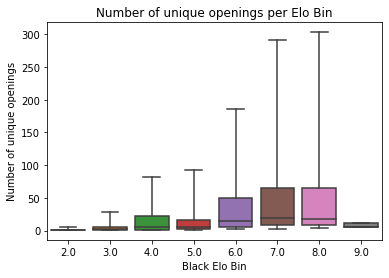

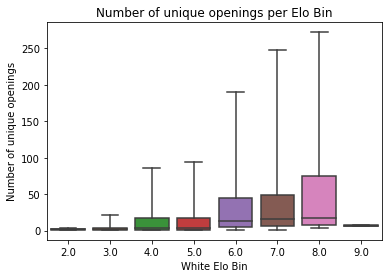

In [21]:
def plot_unique_openings(num_open, colour, bin):
  import seaborn as sns
  import matplotlib.pyplot as plt

  fig = plt.figure()
  sns.boxplot(x=num_open[bin], y=num_open["NoOpen"], whis=[5,95], showfliers=False)
  plt.title("Number of unique openings per Elo Bin")
  plt.xlabel(colour + " Elo Bin")
  plt.ylabel("Number of unique openings")
  fig.savefig(colour + "UniqueOpenings.png", bbox_inches='tight')
  plt.show()

plot_unique_openings(black_unique_openings, "Black", "BlackEloBin")
plot_unique_openings(white_unique_openings, "White", "WhiteEloBin")

We take the dataframe with all the games where the column NoOpen contains the number of unique Openings for either the White or Black player (the function is run once for each) where the value of NoOpen is identical for the respective player. Because this value is the same we only need to keep 1 arbitrary game for each user. To do this we can create a window frame and apply the <code>percentile_approx</code> sql.function function and then compare the player's NoOpen to what the percentile for their rating bin is to see if they play more or less Openings then the rest of the players in their respective rating bin only.

In [22]:
# Complete

def bin_perc(number_white_openings, spark, colour, bin):
  import pyspark.sql.functions as f
  from pyspark.sql.functions import col, row_number

  # Convert pandas df to a spark df
  df = spark.createDataFrame(number_white_openings)

  # We want to query each EloBin separately, so we must use the window function to create these frames
  window = Window.partitionBy(bin)

  # create a function that will be applied over the whole column that finds the 90th
  # percentile for the window in question.
  percentile_ = f.expr('percentile_approx(NoOpen, 0.90)')

  # Create a new column called Percentile which tells us the 95th percentile value for the number of unique openings played
  # This percentile is for the respective EloBin, which is why we apply the window frame
  # we created above.
  df = df.withColumn('Percentile', percentile_.over(window))\
        .withColumn('PercDifference', f.col("NoOpen")-f.col("Percentile"))

  # Create a temporary view
  df.createOrReplaceTempView("winners")
  df = spark.sql("SELECT * FROM winners where PercDifference > 0")

  window2 = Window.partitionBy(colour).orderBy("PercDifference")
  df = df.withColumn("row", row_number().over(window2)).where(col("row") == 1).drop("row").toPandas()

  #These are the players who played more distinct openings than 90% of the other players for their respective EloBins.

  return df

black_lots_openings = bin_perc(number_black_openings, spark, colour="Black", bin="BlackEloBin")
white_lots_openings = bin_perc(number_white_openings, spark, colour="White", bin="WhiteEloBin")

In [23]:
display(black_lots_openings.sort_values(by=['PercDifference'], ascending=False))

,White,Black,Result,WhiteElo,BlackElo,Opening,WhiteEloBin,BlackEloBin,NoOpen,Percentile,PercDifference
0,pikaron,Redneck,1-0,1754.0,1702.0,Mieses Opening,6.0,6.0,1181,488,693
8,t4nk,F1_ALONSO_FERRARI,0-1,1392.0,1849.0,Van Geet Opening,4.0,6.0,856,488,368
5,ricodelacasita,cheesedout,0-1,1749.0,1843.0,Sicilian Defense: French Variation,6.0,6.0,747,488,259
7,bringerwar,Messsi,0-1,1585.0,1762.0,Modern Defense: Standard Defense,5.0,6.0,638,488,150
1,9TT,ChikiPuki,1-0,1539.0,1500.0,Van't Kruijs Opening,5.0,5.0,511,375,136
6,ANDUTU,Kiriush,1-0,1739.0,1737.0,English Opening: Anglo-Indian Defense,6.0,6.0,607,488,119
14,chinokoli,nichiren1967,1-0,1938.0,1880.0,Queen's Gambit Accepted: Saduleto Variation,7.0,6.0,601,488,113
11,maclanie,rapitrance,0-1,1461.0,1628.0,Owen Defense: Smith Gambit,4.0,5.0,488,375,113
19,ThePersianGulf,Atomicangel,1-0,2097.0,1717.0,"Queen's Gambit Refused: Chigorin Defense, Exch...",7.0,6.0,600,488,112
18,german11,meberlioz,0-1,1614.0,1590.0,"Ruy Lopez: Morphy Defense, Caro Variation",5.0,5.0,486,375,111


In [24]:
print(black_lots_openings.head(20)[["Black", "PercDifference"]].sort_values(by="PercDifference", ascending=False))

                Black  PercDifference
0             Redneck             693
8   F1_ALONSO_FERRARI             368
5          cheesedout             259
7              Messsi             150
1           ChikiPuki             136
6             Kiriush             119
14       nichiren1967             113
11         rapitrance             113
19        Atomicangel             112
18          meberlioz             111
3           oilmanesh              88
17      Karen_Armenia              80
13             pronik              79
4            rashit49              76
2             Panevis              40
9            Greenlan              29
12             Romoda              17
10        NoPlayNoFun               7
15            ptdhina               4
16            kent777               1


In [25]:
display(white_lots_openings.sort_values(by=['PercDifference'], ascending=False))

,White,Black,Result,WhiteElo,BlackElo,Opening,WhiteEloBin,BlackEloBin,NoOpen,Percentile,PercDifference
35,german11,SOKOL_71,0-1,1514.0,1616.0,Ruy Lopez: Steinitz Defense,5.0,5.0,1577,417,1160
32,nichiren1967,cheesedout,0-1,1690.0,1876.0,Sicilian Defense: Alapin Variation,5.0,6.0,1066,417,649
22,Oz,humanlist,1-0,1619.0,1238.0,Mieses Opening,5.0,3.0,793,417,376
2,ChikiPuki,Pierro,1-0,1576.0,1492.0,French Defense #2,5.0,4.0,751,417,334
11,rashit49,Karen_Armenia,1-0,1694.0,1647.0,Philidor Defense,5.0,5.0,621,417,204
16,jack0211,Elliot28,1-0,1698.0,1609.0,"Nimzowitsch Defense: Kennedy Variation, Paulse...",5.0,5.0,587,417,170
42,Atomicangel,arina1999,1-0,1692.0,2106.0,Sicilian Defense: Wing Gambit,5.0,8.0,566,417,149
36,lucia11,SonicTheHedgehog,0-1,1402.0,1721.0,Dutch Defense: Korchnoi Attack,4.0,6.0,417,269,148
24,velimaxi,leogron,1-0,1447.0,1500.0,"King's Gambit Accepted, King's Knight Gambit",4.0,5.0,401,269,132
14,sport,shamirbj,1-0,1477.0,1487.0,Owen Defense,4.0,4.0,401,269,132


In [26]:
print(white_lots_openings.head(20)[["White", "PercDifference"]].sort_values(by="PercDifference", ascending=False))

        White  PercDifference
2   ChikiPuki             334
11   rashit49             204
16   jack0211             170
14      sport             132
3     Panevis             122
13    MihaSAH             117
10    sokol88              99
7   oilmanesh              95
5   cesarpr78              91
15    Kiriush              73
4      JohnUA              61
18      Bjerk              51
0      miooim              51
8        jmen              50
19    chesss4              37
12      nazer              28
9      Gardos              17
1      D31283              14
17     Messsi              11
6    Kyklades               3
